In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from joblib import dump as jdump
import numpy as np
import pickle
import random
import os

In [ ]:
PATH2PROJECT = "/content/drive/MyDrive/Projects/EyeTracker/"
MODEL_FOL = "model2"
CHOSEN_INPUTS = [0, 1, 2, 6, 7, 8, 9]
R_TRAIN = 0.85
N_EPOCHS = 15
PATIENCE = 5
MIN_BRIGHTNESS_RATIO = 0.6
MAX_BRIGHTNESS_RATIO = 1.6

In [ ]:
x1_load = []
x2_load = []
y_load = []

dataset_dir = PATH2PROJECT + "dataset/"
datasets_folders = os.listdir(dataset_dir)

for fol in datasets_folders:
    in_blink_out_fol = dataset_dir + f"{fol_num}/in_blink_out/"
    with open(in_blink_out_fol + "x1.pickle", "rb") as f:
        x1_load0 = pickle.load(f)
    with open(in_blink_out_fol + "x2.pickle", "rb") as f:
        x2_load0 = pickle.load(f)
    with open(in_blink_out_fol + "y.pickle", "rb") as f:
        y_load0 = pickle.load(f)
    for (x10, x20, y10) in zip(x1_load0, x2_load0, y_load0):
        x1_load.append(x10)
        x2_load.append(x20)
        y_load.append(y10)

x1_load = np.array(x1_load)
x2_load = np.array(x2_load)
y_load = np.array(y_load)

n_smp, frame_height, frame_width = x1_load.shape[:-1]

print(n_smp, frame_height, frame_width)

4500 48 44


In [ ]:
x2_chs_inp = x2_load[:, CHOSEN_INPUTS]

0


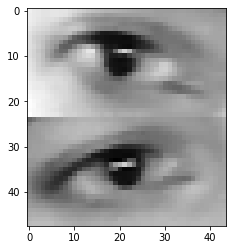

In [ ]:
import matplotlib.pyplot as plt

SAMPLE_NUMBER = 0
print(y_load[SAMPLE_NUMBER])
plt.imshow(x1_load[SAMPLE_NUMBER].reshape((frame_height, frame_width)), cmap="gray")
plt.show()

In [ ]:
# changing brightness
x1_chg_bri = x1_load.copy()
for (i, _) in enumerate(x1_chg_bri):
  r = random.uniform(MIN_BRIGHTNESS_RATIO, MAX_BRIGHTNESS_RATIO)
  x1_chg_bri[i] = (x1_chg_bri[i] * r).astype(np.uint8)

In [ ]:
x1_scaler = 255
x1 = x1_chg_bri / x1_scaler

x2_scaler = StandardScaler()
x2 = x2_scaler.fit_transform(x2_chs_inp)

scalers = [x1_scaler, x2_scaler]
jdump(scalers, PATH2PROJECT + "models/in_blink_out/trained/scalers.bin")

['/content/drive/MyDrive/Projects/EyeTracker/models/in_blink_out/trained/scalers.bin']

In [ ]:
x1_shf, x2_shf, y_shf = shuffle(x1, x2, y_load)

n_train = int(R_TRAIN * n_smp)
n_test = n_smp - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y_train = y_shf[:n_train]
y_test = y_shf[n_train:]

print(x1_train.shape, x1_test.shape, x2_train.shape, x2_test.shape,
      y_train.shape, y_test.shape)

(4050, 48, 44, 1) (450, 48, 44, 1) (4050, 7) (450, 7) (4050,) (450,)


In [ ]:
y_train_ctg = to_categorical(y_train)
y_test_ctg = to_categorical(y_test)

In [ ]:
x_train_list = [x1_train, x2_train]
x_test_list = [x1_test, x2_test]

In [ ]:
cb = EarlyStopping(patience=PATIENCE, verbose=1, restore_best_weights=True)

In [ ]:
raw_models_dir = PATH2PROJECT + "models/in_blink_out/raw/"

model = load_model(raw_models_dir + MODEL_FOL)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 44, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 22, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, show_shapes=True)

In [ ]:
results = model.fit(x_train_list,
                    y_train_ctg,
                    validation_data=(x_test_list, y_test_ctg),
                    epochs=N_EPOCHS,
                    callbacks=cb)

Epoch 1/15
127/127 [==============================] - 2s 13ms/step - loss: 0.5957 - acc: 0.8049 - val_loss: 0.1418 - val_acc: 0.9556
Epoch 2/15
127/127 [==============================] - 1s 10ms/step - loss: 0.1341 - acc: 0.9615 - val_loss: 0.0721 - val_acc: 0.9756
Epoch 3/15
127/127 [==============================] - 1s 11ms/step - loss: 0.0940 - acc: 0.9773 - val_loss: 0.0505 - val_acc: 0.9867
Epoch 4/15
127/127 [==============================] - 1s 10ms/step - loss: 0.0643 - acc: 0.9859 - val_loss: 0.0296 - val_acc: 0.9956
Epoch 5/15
127/127 [==============================] - 1s 11ms/step - loss: 0.0534 - acc: 0.9884 - val_loss: 0.0364 - val_acc: 0.9956
Epoch 6/15
127/127 [==============================] - 1s 10ms/step - loss: 0.0501 - acc: 0.9852 - val_loss: 0.0349 - val_acc: 0.9933
Epoch 7/15
127/127 [==============================] - 1s 11ms/step - loss: 0.0360 - acc: 0.9886 - val_loss: 0.0516 - val_acc: 0.9800
Epoch 8/15
127/127 [==============================] - 1s 10ms/step - 

In [ ]:
yhat_train = model.predict(x_train_list).argmax(1)
yhat_test = model.predict(x_test_list).argmax(1)

Test
0
0


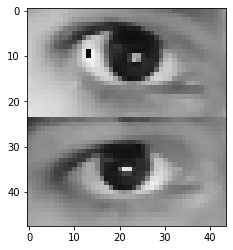

In [ ]:
SAMPLE_NUMBER = 80
print("Test")
print(y_test[SAMPLE_NUMBER])
print(yhat_test[SAMPLE_NUMBER])
plt.imshow(
    (x1_test[SAMPLE_NUMBER].reshape((frame_height, frame_width)) * 255)
    .astype(np.uint8),
    cmap="gray",
    vmin=0,
    vmax=255
    )
plt.show()

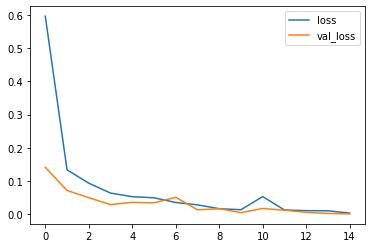

In [ ]:
loss = results.history["loss"]
val_loss = results.history["val_loss"]
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

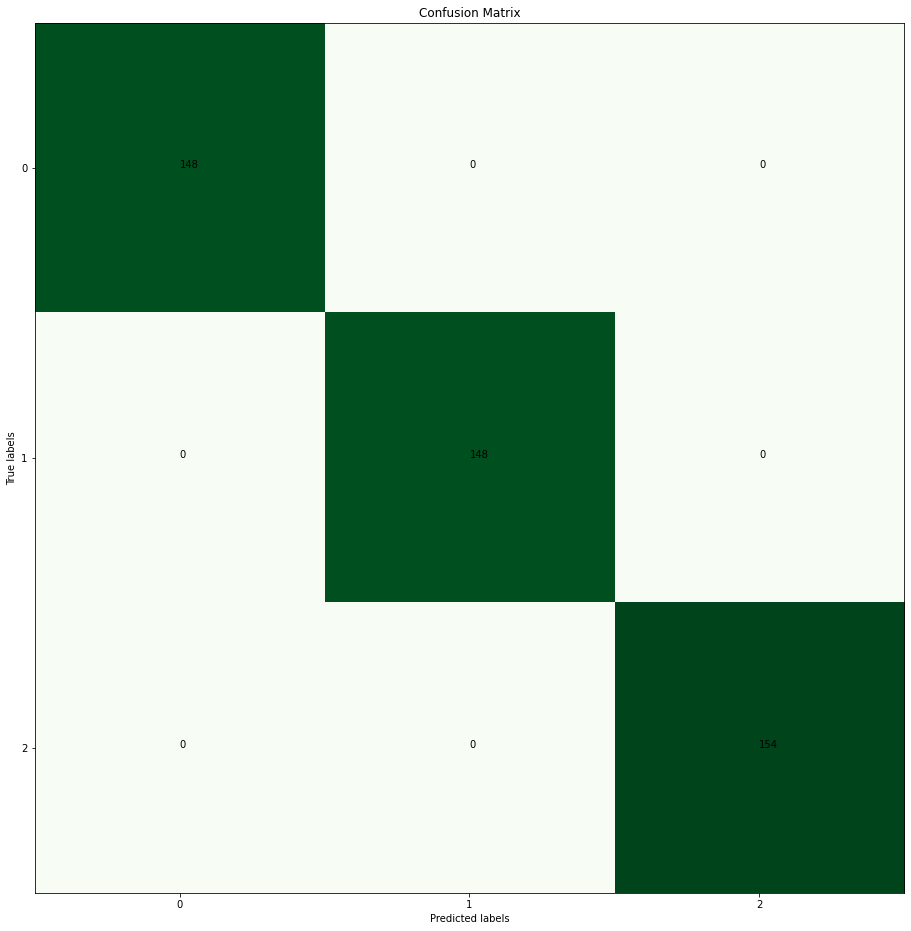

In [ ]:
from sklearn.metrics import confusion_matrix

n_class = y_train_ctg.shape[1]
cm_test = confusion_matrix(y_test, yhat_test)
plt.figure(figsize=(16,16))
plt.imshow(cm_test, cmap=plt.cm.Greens)
class_arr = np.arange(n_class)
plt.xticks(class_arr)
plt.yticks(class_arr)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

for i in range(n_class):
    for j in range(n_class):
        plt.text(i, j, cm_test[j][i])

In [ ]:
model.save(PATH2PROJECT + "models/in_blink_out/trained/" + MODEL_FOL)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/EyeTracker/models/in_blink_out/trained/model2/assets
